In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/kfu-hw-1-classification-2024/test.tsv
/kaggle/input/kfu-hw-1-classification-2024/train.tsv


In [2]:
!pip install pymorphy2

import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud
import spacy
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from textblob import TextBlob
from nltk import download
import pymorphy2
from transformers import pipeline

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 60.2 MB/s eta 0:00:00
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13706 sha256=fe28d5d7af5e33bf81f60cb64832eb0888c5375edcebc2274db77f578e9d9f22
  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506f72c9732fac
Successfully built docopt


In [3]:
test_data = pd.read_csv('/kaggle/input/kfu-hw-1-classification-2024/test.tsv')
train_data = pd.read_csv('/kaggle/input/kfu-hw-1-classification-2024/train.tsv')

train_data.head()

,id,tweet,class
0,760402871867367424,"Настало время для ингаляторов. Дружок, Сальбут...",0
1,1035908416869462016,15) На прошлой зимней олимпиаде большинство лы...,1
2,1089839736427032577,Не соглашусь с заменой ЗОК на метопролол в так...,0
3,779671488748224513,"@di2m1 мезим Смекта Если отравление, то лоперамид",0
4,738309299756240897,Уберите микроволновки и имодиум Действуют соу...,0


**EDA**

In [4]:
train_data['class'].value_counts()

class
0    8683
1     832
Name: count, dtype: int64

In [5]:
print(train_data.isnull().sum())
print(test_data.isnull().sum())

id       0
tweet    0
class    0
dtype: int64
id       0
tweet    0
dtype: int64


In [6]:
print(train_data['tweet'].duplicated().sum())

1


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


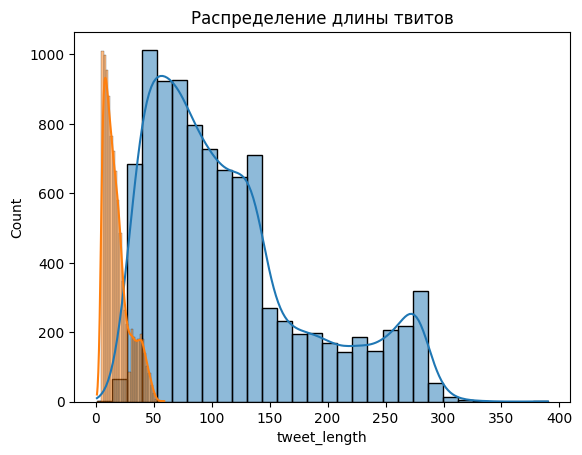

In [7]:
train_data['tweet_length'] = train_data['tweet'].apply(len)
train_data['word_count'] = train_data['tweet'].apply(lambda x: len(x.split()))


sns.histplot(train_data['tweet_length'], kde=True, bins=30)
sns.histplot(train_data['word_count'], kde=True, bins=30)
plt.title("Распределение длины твитов")
plt.show()

**Feature Engineering**

In [8]:
!pip install spacy
!python -m spacy download ru_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 21.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 62.0 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('ru_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [9]:
# Text normalization

download('stopwords')
download('punkt')

stop_words = set(stopwords.words('russian'))
morph = pymorphy2.MorphAnalyzer()

def preprocess_text(text):
    tokens = word_tokenize(text.lower())
    tokens = [morph.parse(token)[0].normal_form for token in tokens if token.isalnum() and token not in stop_words]
    return ' '.join(tokens)

train_data['cleaned_tweet'] = train_data['tweet'].apply(preprocess_text)

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [10]:
nlp = spacy.load('ru_core_news_sm')

def pos_analysis(text):
    doc = nlp(text)
    return [token.pos_ for token in doc]


train_data['pos_tags'] = train_data['cleaned_tweet'].apply(pos_analysis)
train_data.head(5)

,id,tweet,class,tweet_length,word_count,cleaned_tweet,pos_tags
0,760402871867367424,"Настало время для ингаляторов. Дружок, Сальбут...",0,59,8,настать время ингалятор дружок сальбутамол,"[VERB, NOUN, NOUN, PROPN, PROPN]"
1,1035908416869462016,15) На прошлой зимней олимпиаде большинство лы...,1,276,44,15 прошлый зимний олимпиада большинство лыжник...,"[NUM, ADJ, NOUN, NOUN, NOUN, NOUN, VERB, NOUN,..."
2,1089839736427032577,Не соглашусь с заменой ЗОК на метопролол в так...,0,178,31,согласиться замена зок метопролоть такой вид п...,"[VERB, NOUN, NOUN, NOUN, DET, NOUN, ADJ, NOUN,..."
3,779671488748224513,"@di2m1 мезим Смекта Если отравление, то лоперамид",0,49,7,di2m1 мезим смект отравление лоперамид,"[X, VERB, NOUN, NOUN, NOUN]"
4,738309299756240897,Уберите микроволновки и имодиум Действуют соу...,0,52,6,убрать микроволновка имодиум действовать соулмэйт,"[VERB, NOUN, NOUN, VERB, NOUN]"


In [11]:
# Sentiment analysis

classifier = pipeline("sentiment-analysis", model="blanchefort/rubert-base-cased-sentiment")

def analyze_sentiment(text):
    result = classifier(text)[0]  
    return result['label'], result['score']  

train_data[['sentiment_label', 'sentiment_score']] = train_data['cleaned_tweet'].apply(
    lambda x: pd.Series(analyze_sentiment(x))
)

# print(train_data)

config.json:   0%|          | 0.00/943 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/711M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/499 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.40M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Device set to use cpu


Топ-20 слов: [('это', 1387), ('ксанакс', 1332), ('прозак', 910), ('флуоксетин', 756), ('таблетка', 568), ('пить', 557), ('день', 549), ('флуоксетина', 454), ('который', 433), ('препарат', 411), ('сальбутамол', 398), ('такой', 396), ('год', 395), ('ещё', 377), ('тамифить', 375), ('просто', 374), ('паксила', 372), ('лоперамид', 371), ('рецепт', 325), ('очень', 322)]


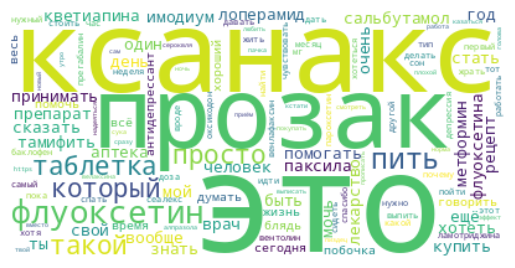

In [12]:
def get_top_n_words(corpus, n=None):
    words = ' '.join(corpus).split()
    return Counter(words).most_common(n)

all_tweets = train_data['cleaned_tweet']
top_words = get_top_n_words(all_tweets, n=20)
print("Топ-20 слов:", top_words)

wordcloud = WordCloud(background_color='white').generate(' '.join(all_tweets))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [13]:
train_data.head()

,id,tweet,class,tweet_length,word_count,cleaned_tweet,pos_tags,sentiment_label,sentiment_score
0,760402871867367424,"Настало время для ингаляторов. Дружок, Сальбут...",0,59,8,настать время ингалятор дружок сальбутамол,"[VERB, NOUN, NOUN, PROPN, PROPN]",NEGATIVE,0.751626
1,1035908416869462016,15) На прошлой зимней олимпиаде большинство лы...,1,276,44,15 прошлый зимний олимпиада большинство лыжник...,"[NUM, ADJ, NOUN, NOUN, NOUN, NOUN, VERB, NOUN,...",NEGATIVE,0.751487
2,1089839736427032577,Не соглашусь с заменой ЗОК на метопролол в так...,0,178,31,согласиться замена зок метопролоть такой вид п...,"[VERB, NOUN, NOUN, NOUN, DET, NOUN, ADJ, NOUN,...",NEGATIVE,0.751479
3,779671488748224513,"@di2m1 мезим Смекта Если отравление, то лоперамид",0,49,7,di2m1 мезим смект отравление лоперамид,"[X, VERB, NOUN, NOUN, NOUN]",NEUTRAL,0.788387
4,738309299756240897,Уберите микроволновки и имодиум Действуют соу...,0,52,6,убрать микроволновка имодиум действовать соулмэйт,"[VERB, NOUN, NOUN, VERB, NOUN]",NEUTRAL,0.829736


In [14]:
train_data['sentiment_label'].value_counts()

sentiment_label
NEUTRAL     5055
NEGATIVE    3615
POSITIVE     845
Name: count, dtype: int64